# Solar Energy Prediction
In this notebook we will try to predict the solar energy production using a few different models. These models will also be evaluated at the end.

* [SARIMA](#sarima)
* [LSTM](#lstm)
* [Bidirectional LSTM](#bidirectional-lstm)
* [CNN](#cnn)
* [Hybrid SARIMA + BiLSTM](#hybird-sarima--bilstm)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

print('Pandas version:', pd.__version__) # 2.2.3
print('Numpy version:', np.__version__) # 1.26.4
print('TensorFlow version:', tf.__version__) # 2.18.0
print('Seaborn version:', sns.__version__) # 0.13.2

Pandas version: 2.2.3
Numpy version: 1.26.4
TensorFlow version: 2.18.0
Seaborn version: 0.13.2


## Load the dataset
We will start with loading the dataset that has both the weather data and the solar energy production data. This is the dataset that has been cleaned and combined in the previous notebooks.

In [2]:
df = pd.read_csv('../data/Model/solar_production_weather.csv')
df

,Date,Time,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor
0,2021-01-01,01:00:00,230,10,20,-3.2,0,0,0,1,2.970833,0,0,0.0,0,0.0
1,2021-01-01,02:00:00,230,20,30,-2.7,0,0,4,7,2.970833,0,0,0.0,0,0.0
2,2021-01-01,03:00:00,220,20,30,-1.1,0,0,15,8,2.970833,0,0,0.0,0,0.0
3,2021-01-01,04:00:00,230,20,40,1.1,0,0,18,8,2.970833,0,0,0.0,0,0.0
4,2021-01-01,05:00:00,230,30,40,1.9,0,0,44,8,2.970833,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26273,2023-12-31,18:00:00,200,70,150,8.6,0,0,75,8,8.829167,0,0,0.0,0,0.0
26274,2023-12-31,19:00:00,200,80,140,8.6,0,0,75,8,8.829167,0,0,0.0,0,0.0
26275,2023-12-31,20:00:00,200,70,150,8.2,0,0,70,8,8.829167,0,0,0.0,0,0.0
26276,2023-12-31,21:00:00,200,70,140,8.1,0,0,70,8,8.829167,0,0,0.0,0,0.0


First we need to merge the date and time columns back into one column.

In [3]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

df.drop(columns=['Date', 'Time'], inplace=True)

cols = ['Datetime'] + [col for col in df.columns if col != 'Datetime']
df = df[cols]
df.head()

,Datetime,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor
0,2021-01-01 01:00:00,230,10,20,-3.2,0,0,0,1,2.970833,0,0,0.0,0,0.0
1,2021-01-01 02:00:00,230,20,30,-2.7,0,0,4,7,2.970833,0,0,0.0,0,0.0
2,2021-01-01 03:00:00,220,20,30,-1.1,0,0,15,8,2.970833,0,0,0.0,0,0.0
3,2021-01-01 04:00:00,230,20,40,1.1,0,0,18,8,2.970833,0,0,0.0,0,0.0
4,2021-01-01 05:00:00,230,30,40,1.9,0,0,44,8,2.970833,0,0,0.0,0,0.0


## Modelling
We will try a few different models to see which one performs the best. We will start with the preprocessing. We will also calculate the standard deviation of the dataset, so we can use this for evaluating the model and define some more functions we will use for evaluating the models.

In [4]:
std = df['volume'].std()

def calculate_rmse_vs_std(rmse, std):
    return (rmse / std) * 100

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'--- {model_name} Evaluation ---')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R² score: {r2}')
    print('--------------------------------\n')
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

#### Feature Selection
These features are selected based on the correlation matrix that was created in the solar energy production eda notebook. The correlation matrix will be shown again for reference. The target is the volume, since this is the total amount of solar energy that is produced.

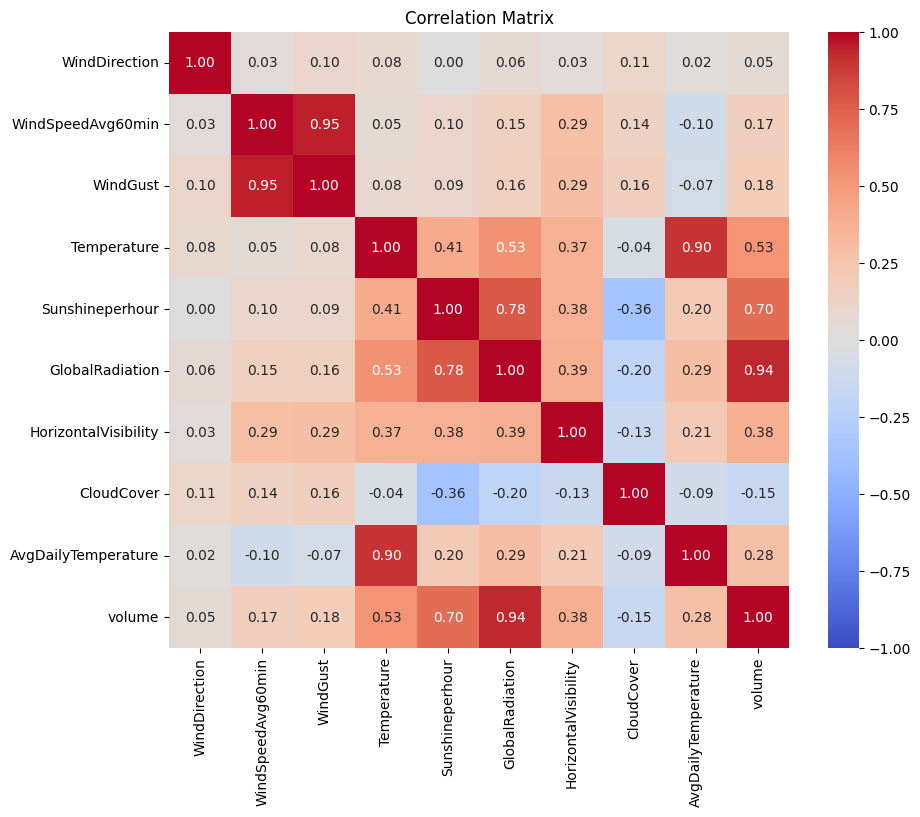

In [6]:
df_corr = df[['WindDirection', 'WindSpeedAvg60min', 'WindGust', 'Temperature',
                                     'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility', 
                                     'CloudCover', 'AvgDailyTemperature', 'volume']]

correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', cbar=True)

plt.title('Correlation Matrix')
plt.show()

In [7]:
features = ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility']
target = 'volume'

### Splitting the data
Next we will split the data into a train and test set, 80% of the data will be used for training and 20% will be used for testing. The data will not be shuffled, since we are using time series data and the order of the dates is important.

In [8]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 26278 observations, of which 21022 are now in the train set, and 5256 in the test set.


## SARIMA
We will start with a SARIMA (Seasonal Autoregressive Integrated Moving Average) model. This is a versatile model that is widely used for time series forecasting. It is an extension of the non-seasonal ARIMA model. The reason why we are using a SARIMA model is because when doing the EDA we found out there are seasonal trends in the production of solar energy.

There are different components of SARIMA:
* <b>S</b>: Seasonal Component. This represents seasonality, which refers to repeating patterns in the data.
* <b>AR</b>: Autoregressive Component. This models the relationship between the current data point and its past values. 
* <b>I</b>: Integrated Component. This indicates differencing, which transforms non-stationary data into stationary data. 
* <b>MA</b>: Moving Average Component. This models the dependency between the current data point and past prediction errors.

<a href="https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/">source</a>

#### Check Stationarity
Before applying SARIMA it is important to check if the time series data is stationary, because this is what SARIMA assumes. Stationarity refers to the statistical properties of a time series remaining constant over time, such as constant mean, constant variance, and constant autocovariance (<a href="https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/">source</a>).

In [9]:
from statsmodels.tsa.stattools import adfuller

y_diff = y.diff().dropna()

adf_test = adfuller(y_diff)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Series is not stationary.")

ADF Statistic: -35.73386222307808
p-value: 0.0


The series is stationary and no differencing is required for the non-seasonal component.

To determine the seasonal period we will plot the autocorrelation.

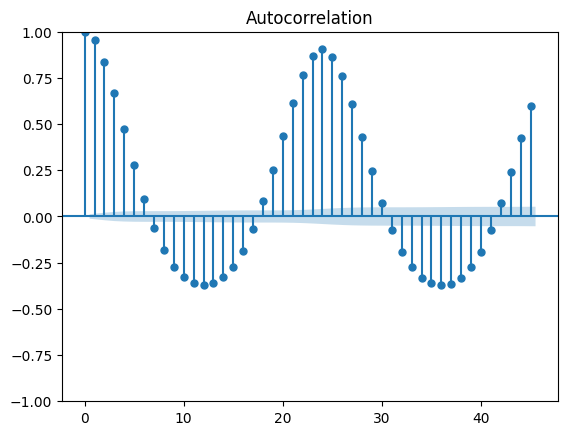

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df[target])
plt.show()

In this plot we can see the peaks are at lag 24 and 48, this means we have a seasonal period of 24, with the data being hourly and having daily seasonality. This makes sense since during the night there is no sunshine so also no solar energy production.

### Modelling

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA parameters
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 24

sarima = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, enforce_invertibility=False)
results = sarima.fit(disp=False)

### Evaluation

In [582]:
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

train_predictions = results.get_prediction(start=0, end=len(y_train)-1, exog=X_train)
y_train_pred = train_predictions.predicted_mean

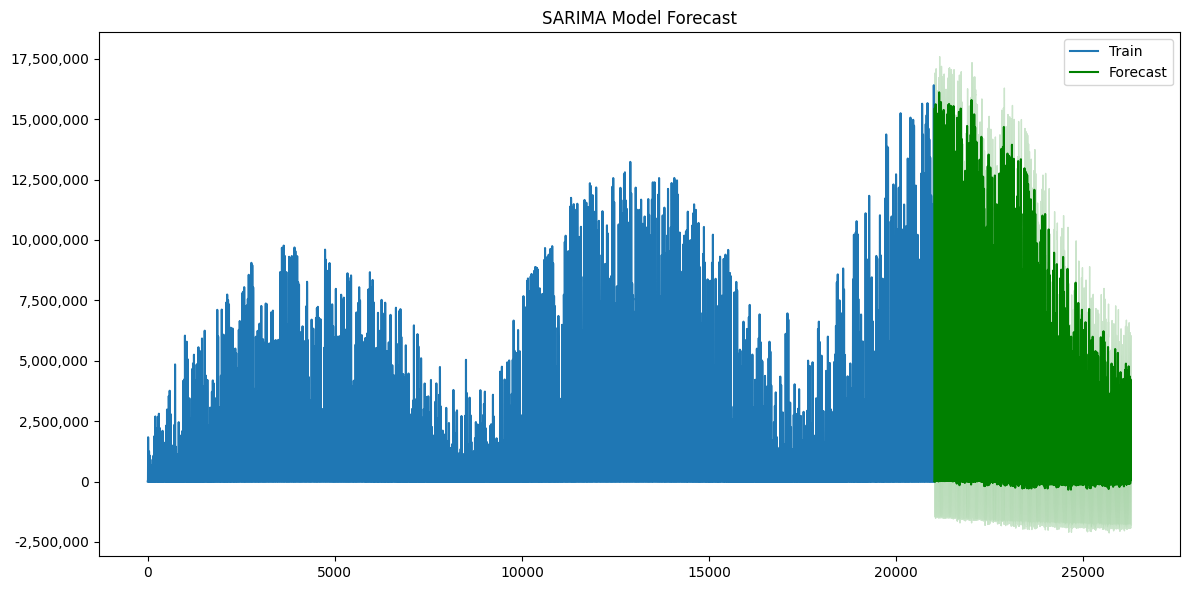

In [583]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(12, 6))

plt.plot(y_train, label='Train')
plt.plot(forecast_mean, label='Forecast', color='green')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMA Model Forecast')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In this plot we can see the forecast of the solar energy production.

In [584]:
sarima_1_train_eval = evaluate_model(y_train, y_train_pred, model_name="Sarima 1 (Train)")
sarima_1_test_eval = evaluate_model(y_test, forecast_mean, model_name="Sarima 1 (Test)")

--- Sarima 1 (Train) Evaluation ---
MAE: 287579.80032304075
RMSE: 596695.804337351
R² score: 0.9565056792345216
--------------------------------

--- Sarima 1 (Test) Evaluation ---
MAE: 560698.3417553224
RMSE: 926697.5709143266
R² score: 0.9494598165057181
--------------------------------



By looking at the R² score we can see the model performs quite well. The train and test R² score are also close to each other so the model is not overfitting.

In [585]:
rmse = sarima_1_test_eval['RMSE']
sarima_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {sarima_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 29.19%


The RMSE is quite large, but if we compare it to the standard deviation it is actually not that bad as it is less than 30% of the std. 
<!-- The RMSE is quite large, this means that the predications deviate significantly from the actual values. The model performs quite poorly. There are a few different explanations on this. The model might not be flexible enough to capture underlying patterns, the seasonal period parameters might not be correct or the selected features might not work for this model. -->

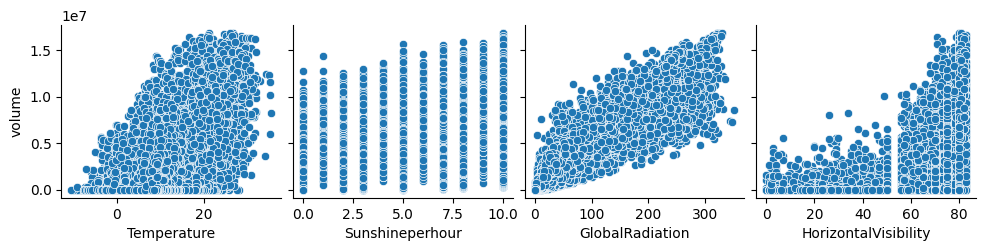

In [586]:
plot = sns.pairplot(df, x_vars=features, y_vars=target)

We will try the same model again, but this time exlude sunshine per hour as a feature, as there is not a strong correlation based on this pairplot.

## SARIMA (2)
We will try the exact same model as before, but now with only `Temperature`, `GlobalRadiation` and `HorizontalVisibility` as features, to see if this makes a significant difference.

In [587]:
features_2 = ['Temperature', 'GlobalRadiation', 'HorizontalVisibility']

In [588]:
X_2 = df[features_2]
y_2 = df[target]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, shuffle=False)
print("There are in total", len(X_2), "observations, of which", len(X_train_2), "are now in the train set, and", len(X_test_2), "in the test set.")

There are in total 26278 observations, of which 21022 are now in the train set, and 5256 in the test set.


In [589]:
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 24

sarima = SARIMAX(y_train_2, exog=X_train_2, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, enforce_invertibility=False)
results = sarima.fit(disp=False)

### Evaluation

In [590]:
forecast = results.get_forecast(steps=len(y_test_2), exog=X_test_2)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

train_predictions = results.get_prediction(start=0, end=len(y_train_2)-1, exog=X_train_2)
y_train_pred = train_predictions.predicted_mean

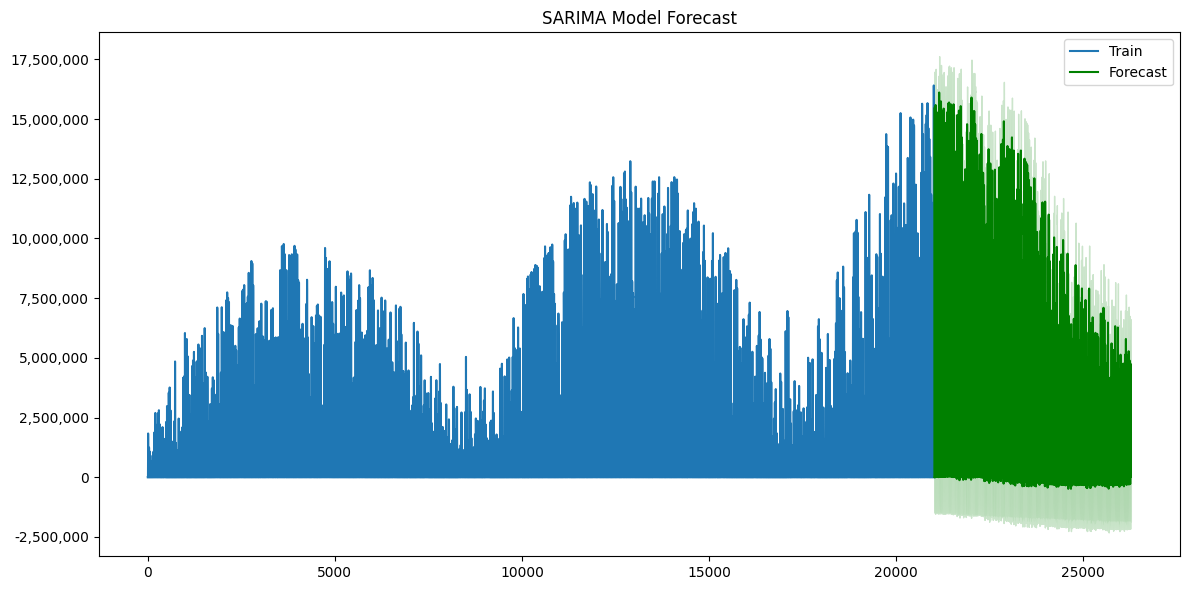

In [591]:
plt.figure(figsize=(12, 6))

plt.plot(y_train_2, label='Train')
plt.plot(forecast_mean, label='Forecast', color='green')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMA Model Forecast')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [592]:
sarima_2_train_eval = evaluate_model(y_train_2, y_train_pred, model_name="Sarima 2 (Train)")
sarima_2_test_eval = evaluate_model(y_test_2, forecast_mean, model_name="Sarima 2 (Test)")

--- Sarima 2 (Train) Evaluation ---
MAE: 293507.02538189956
RMSE: 608750.0641507747
R² score: 0.9547306118450258
--------------------------------

--- Sarima 2 (Test) Evaluation ---
MAE: 583183.9951962349
RMSE: 970537.7766301734
R² score: 0.944564795544211
--------------------------------



The R² is close to the first SARIMA model, which means the `Sunshine per Hour` value does not have a big impact on the results. However, we will include it again in the next models.

In [593]:
rmse = sarima_2_test_eval['RMSE']
sarima_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {sarima_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 30.57%


## SARIMA (3)
This time we will use all of the original features, but change the seasonality parameter to 12, to make it monthly instead of daily. This is to test if the seasonal trend has been selected correctly.

In [594]:
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 12

sarima = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, enforce_invertibility=False)
results = sarima.fit(disp=False)

### Evaluation

In [595]:
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

train_predictions = results.get_prediction(start=0, end=len(y_train)-1, exog=X_train)
y_train_pred = train_predictions.predicted_mean

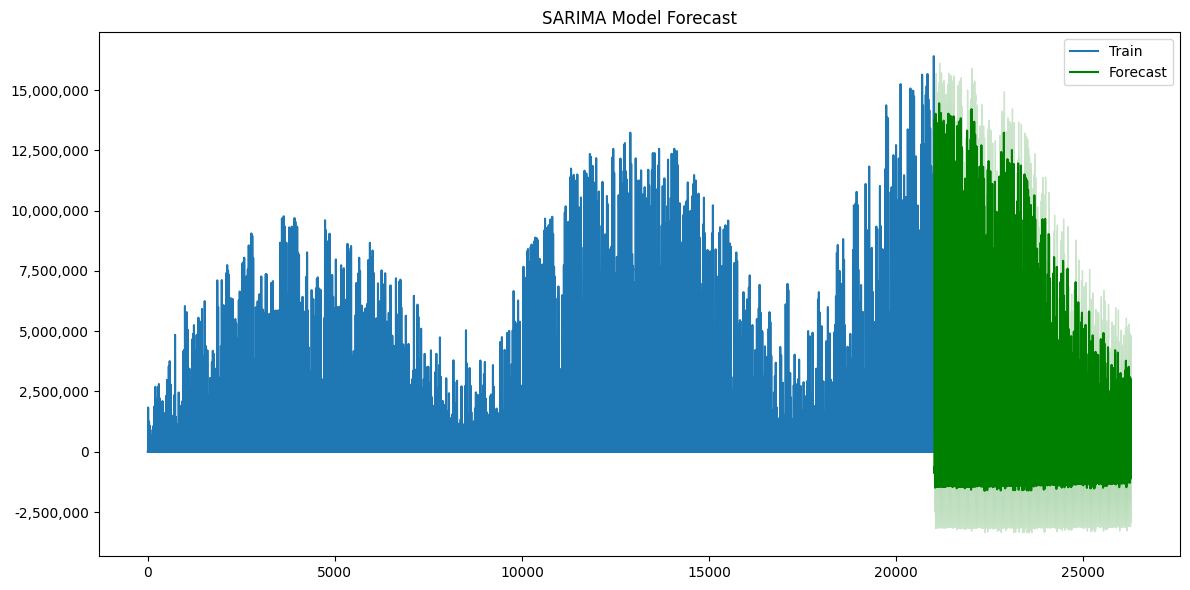

In [596]:
plt.figure(figsize=(12, 6))

plt.plot(y_train, label='Train')
plt.plot(forecast_mean, label='Forecast', color='green')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMA Model Forecast')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [597]:
sarima_3_train_eval = evaluate_model(y_train, y_train_pred, model_name="Sarima 3 (Train)")
sarima_3_test_eval = evaluate_model(y_test, forecast_mean, model_name="Sarima 3 (Test)")

--- Sarima 3 (Train) Evaluation ---
MAE: 356794.2656424303
RMSE: 633647.0795544424
R² score: 0.9509519822906729
--------------------------------

--- Sarima 3 (Test) Evaluation ---
MAE: 991985.4154755238
RMSE: 1300543.3911838203
R² score: 0.900457061224498
--------------------------------



The R² score is still quite high, however the test R² score is lower than the train R² score, which could mean the model is slightly overfitting.

In [598]:
rmse = sarima_3_test_eval['RMSE']
sarima_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {sarima_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 40.96%


The first SARIMA model performed the best, this also confirms the daily seasonal trend.

## LSTM
Next we will try a LSTM (Long Short-Term Memory) model. This is an advanced recurrent neural network, that is ideal for time series. LSTM models are capable of learning long-term dependencies is sequential data. It involves a memory cell, which is controlled by three gates: the input gate, the forget gate and the output gate. The gates decide what information to add to, remove from and output from the memory cell. This allows LSTM networks to selectively retain or discard information, which allows for it to learn long-term dependencies (<a href="https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/">source</a>).

### Feature Selection
We will use the same features we used for our first SARIMA model.

In [599]:
features # to confirm the right features are used

['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility']

### Scaling the data
The data should be scaled to values between 0 and 1. This needs to be done first because neural networks are sensitive to the scale of input data and the activation functions that are used work best with scaled inputs. For this we will use a MinMaxScaler, this uses the min and max values of the data for scaling.

In [600]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[features])
y_scaled = target_scaler.fit_transform(df[[target]])

### Create sequences
We will create sequences of consecutive data points as the input and the output of the target variable corresponding to the time following the sequence. 

In [601]:
sequence_length = 24

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

### Splitting the data
Again the dataset will be split into a train and test set, with 80% of the data used for training and 20% used for testing. This will be done by slicing the data, so the sequenced time series data is correcly split.

In [602]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

### Modelling
We will start with creating a model that has two LSTM layers, both of them have 50 LSTM units. A ReLU (Rectified Linear Unit) activation function will be used, to introduce non-linearity so the model can learn complex patterns. Dropout will be added to avoid overfitting, 20% of the inputs will randomly be set to 0 during training. The final layer is the dense layer, this is a fully connected layer that outputs a single value. The Adam (Adaptive Moment Estimation) algorithm will be used for optimisation, to adjust the learning rate during training.

In [603]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 24, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [604]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0127 - val_loss: 0.0069
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0030 - val_loss: 0.0086
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0027 - val_loss: 0.0099
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 10/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0073
Epoch 11/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 12/100
526/526 ━━━━━━━━━━━━━━━━━━━━

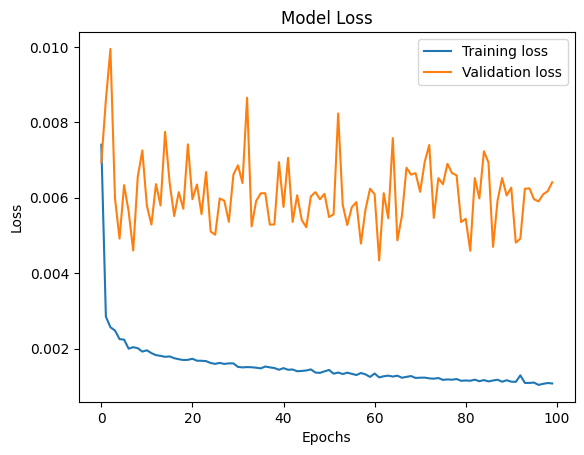

In [605]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

By looking at this graph we can see the validation loss is all over the place and does not decrease over time. This indicates that the model is not effectively learning.

### Evaluation

In [606]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.00966962892562151


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


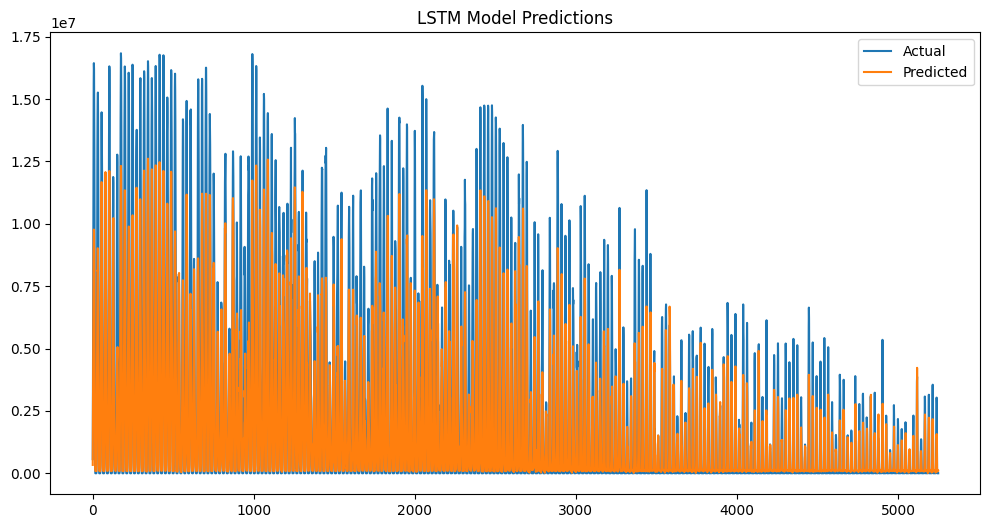

In [607]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()


In [608]:
lstm_1_train_eval = evaluate_model(y_train_original, y_train_pred, model_name="LSTM 1 (Train)")
lstm_1_test_eval = evaluate_model(y_test_original, y_pred, model_name="LSTM 1 (Test)")

--- LSTM 1 (Train) Evaluation ---
MAE: 352966.8023339253
RMSE: 718194.0943530718
R² score: 0.9370304721831665
--------------------------------

--- LSTM 1 (Test) Evaluation ---
MAE: 908714.012287745
RMSE: 1655192.8133935297
R² score: 0.8388520555549402
--------------------------------



The R² score for the train data is still quite high, however the R² for the test set is significantly lower, which means the model is overfitted.

In [609]:
rmse = lstm_1_test_eval['RMSE']
lstm_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'LSTM RMSE as % of STD: {lstm_rmse_std:.2f}%')

LSTM RMSE as % of STD: 52.13%


By looking at the RMSE we can conclude that the model does not perform well, the RMSE is a lot higher than the SARIMA model. This might be because we do not have enough data, so the model cannot effectively learn the temporal patterns.

## LSTM (2)
We will try a regular LSTM one more time to see if we can improve the performance. We will use the exact same features and train and test set as the previous LSTM model.

### Modelling
This time we have added another LSTM layer and lowered the dropout to 0.1. Adding the extra layer makes the model more capable of finding deeper temporal patterns. However, this also increases the risk of overfitting. The lower dropout makes it possible to retain more information during training, however this also increases the risk of overfitting.

In [610]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_65 (LSTM)                  │ (None, 24, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 24, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,729 (373.94 KB)

 Trainable params: 95,729 (373.94 KB)

 Non-trainable params: 0 (0.00 B)

In [611]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

This time we will also add early stopping and adjust the learning rate dynamically during training, to prevent overfitting.

In [612]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, 
                 callbacks=[early_stopping, reduce_lr])

Epoch 1/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0806 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0071 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0057 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0049 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0046 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0046 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0039 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0041 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0041 - val_loss: 0.0104 - learning_rate

We can see the model stopped training after 16 epochs.

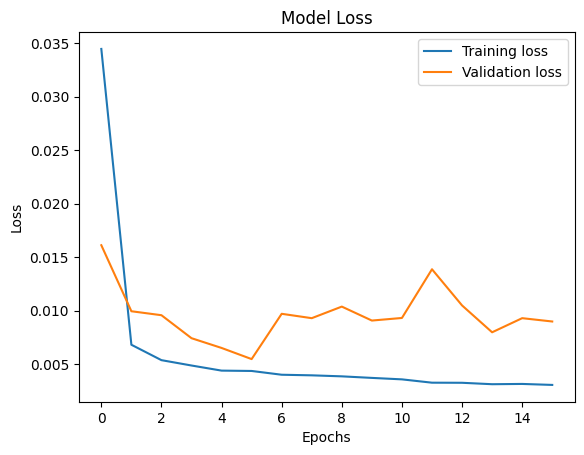

In [613]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The validation loss is closer to the training loss, however the model is still not effectively learning.

### Evaluation

In [614]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.007399041671305895


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


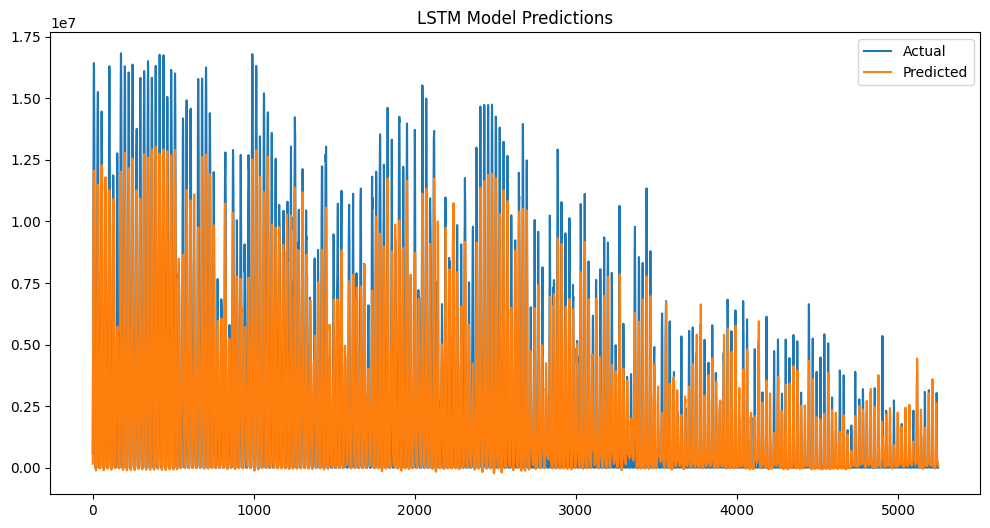

In [615]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()

In [616]:
lstm_2_train_eval = evaluate_model(y_train_original, y_train_pred, model_name="LSTM 2 (Train)")
lstm_2_test_eval = evaluate_model(y_test_original, y_pred, model_name="LSTM 2 (Test)")

--- LSTM 2 (Train) Evaluation ---
MAE: 643106.743286666
RMSE: 1110377.474069127
R² score: 0.8494821303201
--------------------------------

--- LSTM 2 (Test) Evaluation ---
MAE: 775063.0547020894
RMSE: 1340772.8727696878
R² score: 0.8942603143155897
--------------------------------



The R² scores are similar to the previous LSTM model, the model is still overfitting, however it is slightly less overfitted than the previous LSTM model.

In [617]:
rmse = lstm_2_test_eval['RMSE']
lstm_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'LSTM RMSE as % of STD: {lstm_rmse_std:.2f}%')

LSTM RMSE as % of STD: 42.23%


This model performed slightly better than the first LSTM model, however it still does not perform as good as the SARIMA model.

## Bidirectional LSTM
By adding a bidirectional layer we can allow the LSTM to learn both past and future sequences, this could help improve the model.

### Modelling
We will start with two bidirectional layers and a dropout rate of 0.1.

In [618]:
from tensorflow.keras.layers import Bidirectional

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.1))

model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_25                │ (None, 24, 100)        │        22,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 100)            │        60,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,929 (347.38 KB)

 Trainable params: 88,929 (347.38 KB)

 Non-trainable params: 0 (0.00 B)

In [619]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

Again we will use early stopping and adjust the learning rate dynamically during training.

In [620]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, 
                 callbacks=[early_stopping, reduce_lr])

Epoch 1/100


526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0136 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0031 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0024 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0022 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0022 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0021 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0021 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0019 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0019 - val_loss: 0.0071 - learning_rate: 0.0010
Epo

The model stops after 15 epochs this time.

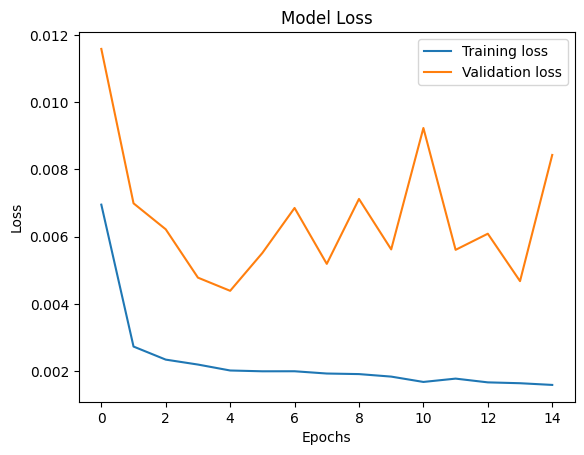

In [621]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The validation loss line is all over the place again, the model does not learn effictively.

### Evaluation

In [622]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.007081260904669762


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


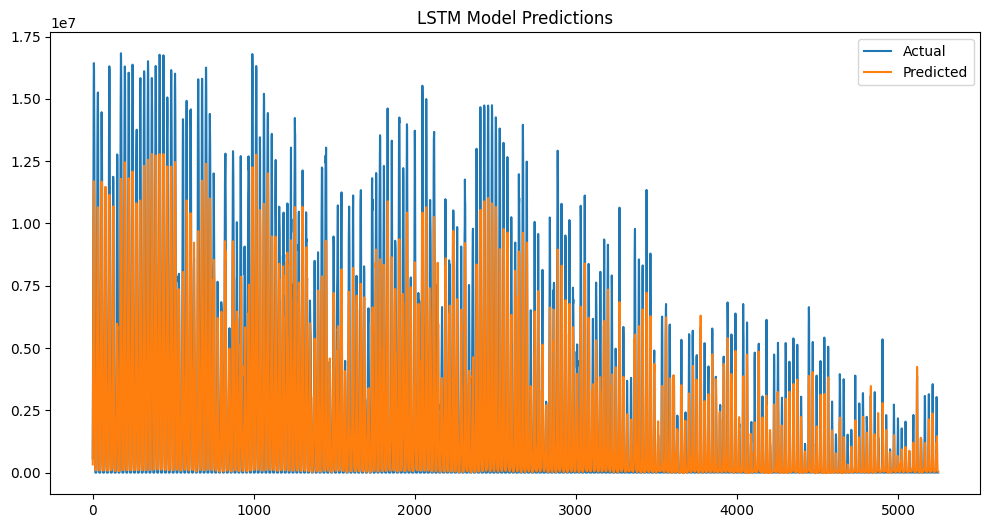

In [623]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()

In [624]:
bilstm_1_train_eval = evaluate_model(y_train_original, y_train_pred, model_name="Bi-LSTM 1 (Train)")
bilstm_1_test_eval = evaluate_model(y_test_original, y_pred, model_name="Bi-LSTM 1 (Test)")

--- Bi-LSTM 1 (Train) Evaluation ---
MAE: 437672.4656620053
RMSE: 811239.5566183956
R² score: 0.9196575603064576
--------------------------------

--- Bi-LSTM 1 (Test) Evaluation ---
MAE: 756344.561720433
RMSE: 1394718.291998307
R² score: 0.8855803592879783
--------------------------------



We can see the R² score is higher than the LSTM model and it is also slightly less overfitted. However the training graph shows the model is performing worse than the LSTM model.

In [625]:
rmse = bilstm_1_test_eval['RMSE']
lstm_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'Bi-LSTM RMSE as % of STD: {lstm_rmse_std:.2f}%')

Bi-LSTM RMSE as % of STD: 43.93%


## Bidirectional LSTM (2)
We will try another Bidirectional LSTM and change some parameters and layers, to see if we can improve performance. We will also add a third BiLSTM layer to the model, to make it more complex.

In [626]:
model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(Bidirectional(LSTM(25, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(25, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(25, activation='relu', kernel_regularizer=l2(0.001))))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_27                │ (None, 24, 50)         │         6,000 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ (None, 24, 50)         │        15,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_29                │ (None, 50)             │        15,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,057 (168.19 KB)

 Trainable params: 43,057 (168.19 KB)

 Non-trainable params: 0 (0.00 B)

In [627]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

In [628]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, 
                 callbacks=[early_stopping, reduce_lr])

Epoch 1/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.1099 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0057 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0042 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0040 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0041 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0030 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0028 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0028 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0026 - val_loss: 0.0074 - learning_rate

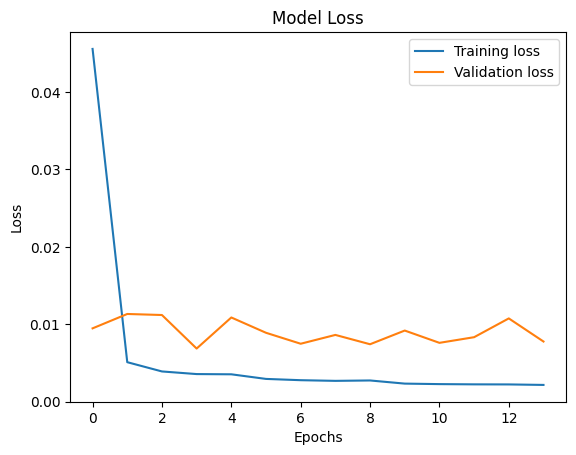

In [629]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

This time the validation loss is closer to the training loss, however it is still not optimal.

### Evaluation

In [630]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.010722937062382698


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


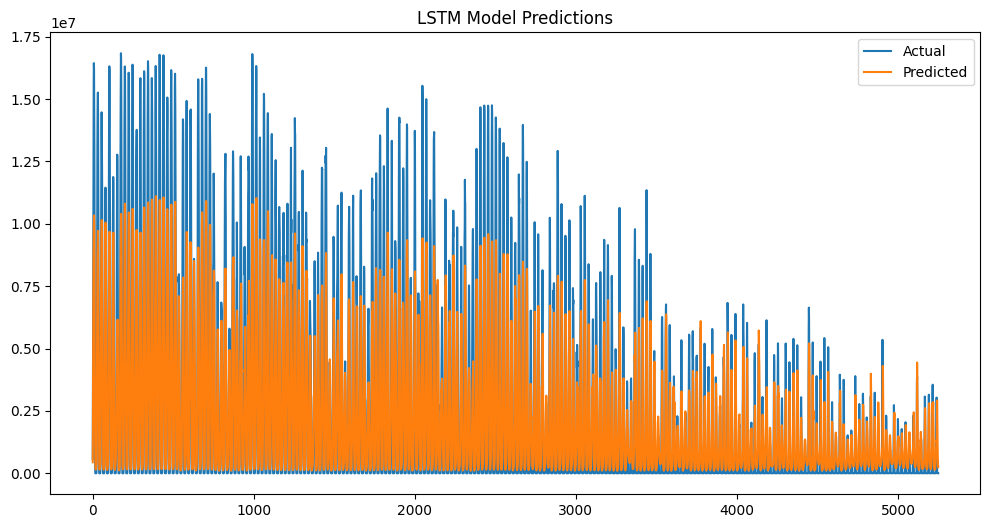

In [631]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()

In [632]:
bilstm_2_train_eval = evaluate_model(y_train_original, y_train_pred, model_name="Bi-LSTM 2 (Train)")
bilstm_2_test_eval = evaluate_model(y_test_original, y_pred, model_name="Bi-LSTM 2 (Test)")

--- Bi-LSTM 2 (Train) Evaluation ---
MAE: 705690.6668578596
RMSE: 1042349.8473533491
R² score: 0.8673602203567671
--------------------------------

--- Bi-LSTM 2 (Test) Evaluation ---
MAE: 1053256.3419452843
RMSE: 1681278.8930521295
R² score: 0.8337325991556445
--------------------------------



The R² is lower this time and however, the train and test R² scores are closer to each other, indicating it is less overfitted this time. 

In [633]:
rmse = bilstm_2_test_eval['RMSE']
lstm_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'Bi-LSTM RMSE as % of STD: {lstm_rmse_std:.2f}%')

Bi-LSTM RMSE as % of STD: 52.96%


The RMSE is still really high compared to the standard deviation. This means the model is not that great.

## CNN
CNNs are initially designed for image analysis, but can be used for processing sequential data like time series. The model uses convolutional layers that focus on local regions of the input data. This enables them to capture short-term patterns effectively. Because the model consists of multiple convolutional layers they can also learn hierarchical representations representations of data, which makes them capable of capturing both short-term and long-term dependencies (<a href='https://thejaskiran99.medium.com/unlocking-the-potential-of-convolutional-neural-networks-cnns-in-time-series-forecasting-b2fac329e184'>source</a>). We will use a CNN model just to see how this works.

### Modelling

In [634]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (21003, 24, 4)
Shape of X_test: (5251, 24, 4)


We will add two one-dimentional convolutional layers and two dense layers.

In [635]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 22, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 9, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,649 (154.88 KB)

 Trainable params: 39,649 (154.88 KB)

 Non-trainable params: 0 (0.00 B)

In [636]:
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0142 - val_loss: 0.0108
Epoch 2/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0049 - val_loss: 0.0105
Epoch 3/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 4/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0036 - val_loss: 0.0117
Epoch 5/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0034 - val_loss: 0.0090
Epoch 6/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - val_loss: 0.0103
Epoch 7/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - val_loss: 0.0085
Epoch 8/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0030 - val_loss: 0.0110
Epoch 9/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 10/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0028 - val_loss: 0.0124
Epoch 11/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0029 - val_loss: 0.0106
Epoch 12/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

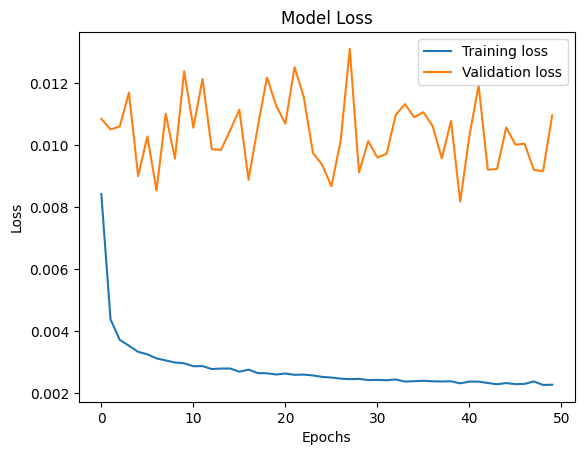

In [637]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

By looking at this graph we can see this model performs very poorly, the training loss does  go down but the validation loss is extremely high. The model is not learning anything.

### Evaluation

In [638]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.017198288813233376


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


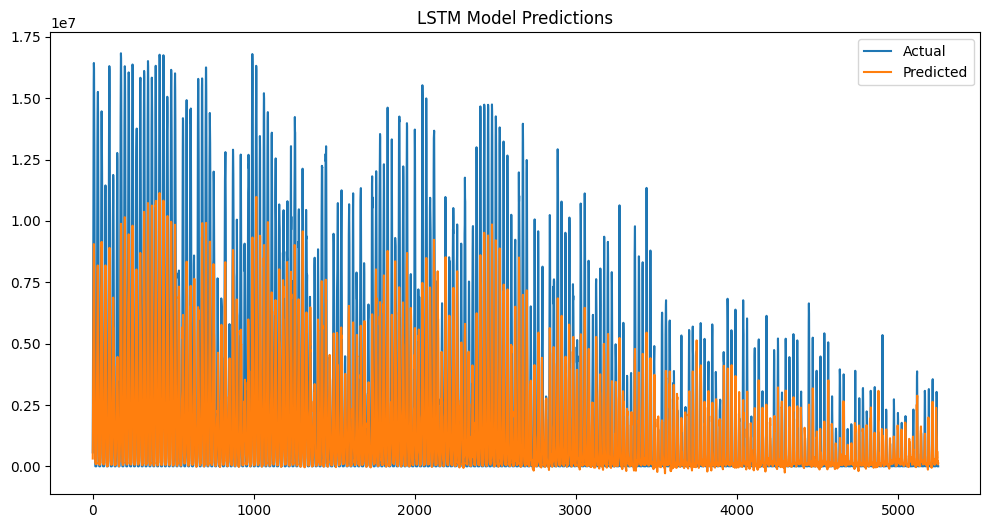

In [639]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

y_train_pred_scaled = model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled)
y_train_original = target_scaler.inverse_transform(y_train)

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()

In [640]:
cnn_train_eval = evaluate_model(y_train_original, y_train_pred, model_name="CNN (Train)")
cnn_test_eval = evaluate_model(y_test_original, y_pred, model_name="CNN (Test)")

--- CNN (Train) Evaluation ---
MAE: 556053.5624801555
RMSE: 1079895.2888446571
R² score: 0.8576327584252439
--------------------------------

--- CNN (Test) Evaluation ---
MAE: 1224472.934778083
RMSE: 2207427.0856923894
R² score: 0.7133840727904766
--------------------------------



The R² score is also the lowest of all models and the test R² score is significantly lower than the train R². This means the model is overfitting.

In [641]:
rmse = cnn_test_eval['RMSE']
lstm_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'CNN RMSE as % of STD: {lstm_rmse_std:.2f}%')

CNN RMSE as % of STD: 69.53%


We can see the CNN model does not perform great, in fact it has the worst performance of all models. Because this was just a test to see how it performs and a LSTM model makes more sense we will not try to improve the CNN model.

## Hybird SARIMA + BiLSTM
Finally we will try a hybrid SARIMA and BiLSTM model. The SARIMA model performed the best out of all the models, however since we do want to include some more deep learning we will try to combine this with the BiLSTM model. This model was chosen because it performed the best out of all the deap learning models. The original features and target will be used.

In [642]:
print(features)
print(target)

['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility']
volume


In [643]:
X_hybrid = df[features].values
y_hybrid = df[target].values

### Train/test split
We will start with splitting the data again, to make sure all values are correct for this model.

In [644]:
train_size = int(len(df) * 0.8)
X_train_hybrid, X_test_hybrid = X_hybrid[:train_size], X_hybrid[train_size:]
y_train_hybrid, y_test_hybrid = y_hybrid[:train_size], y_hybrid[train_size:]

### Modelling
We will start with fitting the SARIMA model.

In [645]:
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 24

sarima_model = SARIMAX(y_train_hybrid, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

Next we will make predictions on the train and test set.

In [646]:
sarima_train_preds = sarima_results.predict(start=0, end=len(y_train_hybrid)-1)
sarima_test_preds = sarima_results.predict(start=len(y_train_hybrid), end=len(y_train_hybrid)+len(y_test_hybrid)-1)

After this we will calculate the residuals, this is the difference between the actual and predicted values.

In [647]:
train_residuals = y_train_hybrid - sarima_train_preds
test_residuals = y_test_hybrid - sarima_test_preds

### BiLSMT
Next we will train the BiLSTM model on the SARIMA residuals. The data first need to be scaled for the BiLSTM model. Next we will create new sequences for the BiLSTM mdoel

In [648]:
scaler = MinMaxScaler()

def create_sequences_hybrid(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 24

train_residuals_scaled = scaler.fit_transform(train_residuals.reshape(-1, 1))
X_bilstm_train, y_bilstm_train = create_sequences_hybrid(train_residuals_scaled, sequence_length)

test_residuals_scaled = scaler.fit_transform(test_residuals.reshape(-1, 1))
X_bilstm_test, y_bilstm_test = create_sequences_hybrid(test_residuals_scaled, sequence_length)

We will use the same BiLSTM model as before.

In [649]:
bilstm_model = Sequential()

bilstm_model.add(Input(shape=(X_bilstm_train.shape[1], X_bilstm_train.shape[2])))

bilstm_model.add(Bidirectional(LSTM(25, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.2))

bilstm_model.add(Bidirectional(LSTM(25, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.2))

bilstm_model.add(Bidirectional(LSTM(25, activation='relu', kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.2))

bilstm_model.add(Dense(128, activation='relu'))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
bilstm_model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_30                │ (None, 24, 50)         │         5,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 24, 50)         │        15,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 50)             │        15,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,457 (165.85 KB)

 Trainable params: 42,457 (165.85 KB)

 Non-trainable params: 0 (0.00 B)

In [650]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

In [651]:
hist = bilstm_model.fit(X_bilstm_train, y_bilstm_train, epochs=100, batch_size=32, validation_split=0.2, 
                 callbacks=[early_stopping, reduce_lr])

Epoch 1/100


525/525 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.1210 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0070 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0048 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0045 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0046 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0044 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0044 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 8/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0045 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 9/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0044 - val_loss: 0.0066 - learning_rate: 0.0010
Epo

It stops training after 31 epochs.

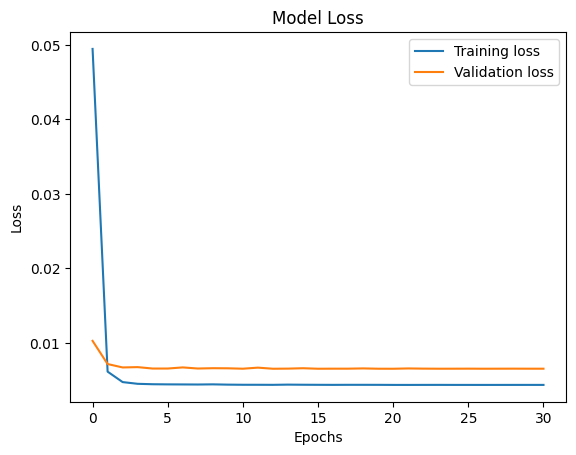

In [652]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Both the training and validation loss do not seem to go down as much, however the validation loss does appear to be stable. This is an improvement compared to the other deep learning models.

### Evaluation
For the evaluation we will combine the predictions of the SARIMA model and the BiLSTM model. The predictions need to be scaled back to the original values.

In [653]:
bilstm_train_preds = bilstm_model.predict(X_bilstm_train)
bilstm_test_preds = bilstm_model.predict(X_bilstm_test)

bilstm_train_preds = scaler.inverse_transform(bilstm_train_preds)
bilstm_test_preds = scaler.inverse_transform(bilstm_test_preds)

657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [654]:
final_train_preds = sarima_train_preds[sequence_length:] + bilstm_train_preds.flatten()
final_test_preds = sarima_test_preds[sequence_length:] + bilstm_test_preds.flatten()

actual_train = y_train_hybrid[sequence_length:]
actual_test = y_test_hybrid[sequence_length:]

In [655]:
sarima_train_metrics = evaluate_model(y_train_hybrid, sarima_train_preds, model_name="SARIMA (Train)")
sarima_test_metrics = evaluate_model(y_test_hybrid, sarima_test_preds, model_name="SARIMA (Test)")

hybrid_train_metrics = evaluate_model(actual_train, final_train_preds, model_name="Hybrid SARIMA-BiLSTM (Train)")
hybrid_test_metrics = evaluate_model(actual_test, final_test_preds, model_name="Hybrid SARIMA-BiLSTM (Test)")


--- SARIMA (Train) Evaluation ---
MAE: 283959.5954514571
RMSE: 430672.20300266077
R² score: 0.9773420680280893
--------------------------------

--- SARIMA (Test) Evaluation ---
MAE: 1569161.3567607284
RMSE: 2452493.4821308823
R² score: 0.6460218225974763
--------------------------------

--- Hybrid SARIMA-BiLSTM (Train) Evaluation ---
MAE: 671905.4018190418
RMSE: 762556.7070172672
R² score: 0.9290211104632674
--------------------------------

--- Hybrid SARIMA-BiLSTM (Test) Evaluation ---
MAE: 1680227.1670481984
RMSE: 2318722.783055607
R² score: 0.6808094676884712
--------------------------------



By looking at these metrics we can see the hybrid model performs slightly better than the SARIMA model, but the high difference between the train and test R² score shows the model is overfitting. It is not effectly learning the residuals. 

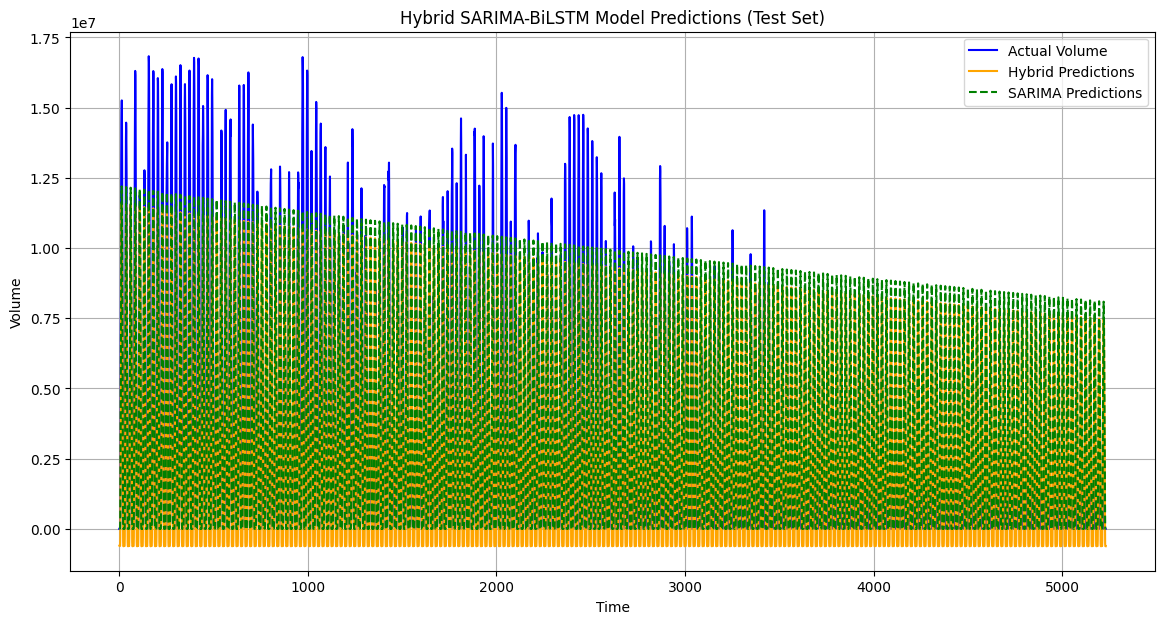

In [656]:
plt.figure(figsize=(14, 7))
plt.plot(actual_test, label="Actual Volume", color="blue")
plt.plot(final_test_preds, label="Hybrid Predictions", color="orange")
plt.plot(sarima_test_preds[sequence_length:], label="SARIMA Predictions", color="green", linestyle="--")
plt.title("Hybrid SARIMA-BiLSTM Model Predictions (Test Set)")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.grid()
plt.show()

The predictions are all over the place.

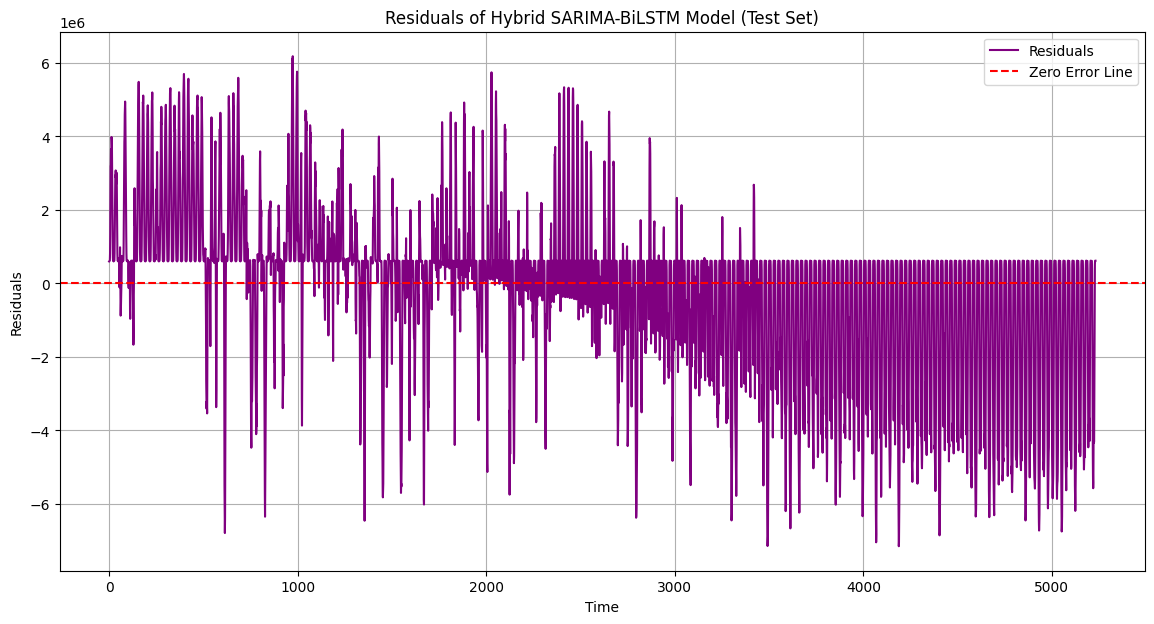

In [657]:
residuals_test = actual_test - final_test_preds

plt.figure(figsize=(14, 7))
plt.plot(residuals_test, label="Residuals", color="purple")
plt.axhline(y=0, color="red", linestyle="--", label="Zero Error Line")
plt.title("Residuals of Hybrid SARIMA-BiLSTM Model (Test Set)")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.grid()
plt.show()

This plot visualises the residuals of the Hybrid SARIMA + BiLSTM model on the test set. We can see the model is consistently making errors when predicting the solar energy production.

## Conclusion
After testing some different models we can conclude that the statistical SARIMA model works best for this dataset. It performs the best of all models we have tried by far. It also does not show any signs of overfitting. None of the deep learning models we have tried showed great results. Maybe the results can be improved if we have more data to train the model, since we are using only 3 years worth of data right now.